In [1]:
#Run only once
%load_ext autoreload
%autoreload 2

In [2]:
cd /home/DeepLearningMachine/JointAngleMeasurement

/home/DeepLearningMachine/JointAngleMeasurement


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from PIL import Image, ImageOps
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import itertools
import imutils
from src.helper_functions import *

import logging
import math
import slidingwindow as sw
import time


Using TensorFlow backend.


In [4]:
#Fix cuDNN incompatibility issue
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
train_path = 'data/Poses/train'
valid_path = 'data/Poses/valid'
test_path = 'data/Poses/test'

#Load in images and place them into training batches
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224, 224), classes=['squatting', 'bending', 'raising_shoulders'], batch_size=5)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224, 224), classes=['squatting', 'bending', 'raising_shoulders'], batch_size=3)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=['squatting', 'bending', 'raising_shoulders'], batch_size=5)

Found 285 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Found 39 images belonging to 3 classes.


In [6]:
imgs, labels = next(train_batches)

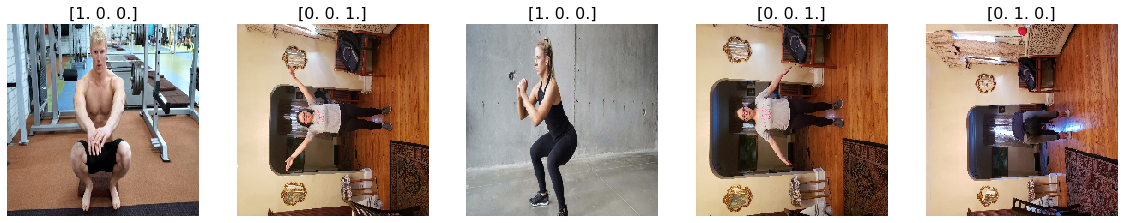

In [7]:
plots(imgs, titles=labels)

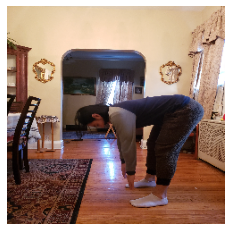

In [8]:
bending_img = cv.imread('data/Poses/train/bending/20200511_190442.jpg')
bending_img = cv.resize(bending_img, (244, 244))
plt.axis('off')
plt.imshow(cv.cvtColor(bending_img, cv.COLOR_BGR2RGB))
plt.show()

In [9]:
Pose_Analyzer_Model = tf.keras.models.load_model('saved_model_info/Pose_Analyzer_VGG16_model.h5')

In [10]:
test_imgs, test_labels = next(test_batches)

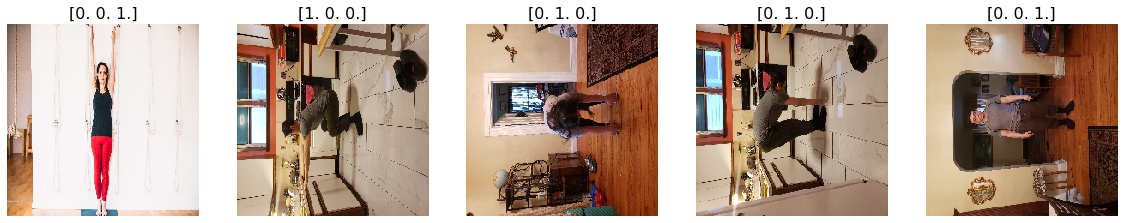

In [11]:
plots(test_imgs, titles=test_labels)

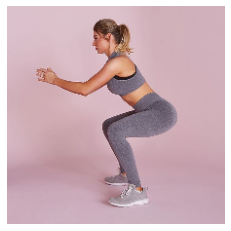

In [14]:
unknown_img = cv.imread('data/Poses/test/squatting/squat_017.jpg')
unknown_img = cv.resize(unknown_img, (224, 224))
plt.imshow(cv.cvtColor(unknown_img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [12]:
#Joint Analysis Setup
protoFile = "openpose/models/pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
weightsFile = "openpose/models/pose/mpi/pose_iter_160000.caffemodel"
# Read the network into Memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

In [532]:
# Read image

# Specify the input image dimensions


#frame = cv2.imread("/home/DeepLearningMachine/JointAngleMeasurement/data/Poses/test/squatting/squat_017.jpg")
unknown_img_classify = cv.imread('data/Poses/test/bending/20200511_190624.jpg')

inWidth = 224
inHeight = 224

unknown_img_classify = cv.resize(unknown_img_classify, (inWidth, inHeight))

unknown_img = cv.imread('data/Poses/test/bending/20200511_190624.jpg')
unknown_img = cv.resize(unknown_img, (2*inWidth, 2*inHeight))
width, height, channels = unknown_img.shape
	 
# Prepare the frame to be fed to the network
inpBlob = cv.dnn.blobFromImage(unknown_img, 1.0/255, (2*inWidth, 2*inHeight), (0, 0, 0), swapRB=False, crop=False)
	 
# Set the prepared object as the input blob of the network
net.setInput(inpBlob)

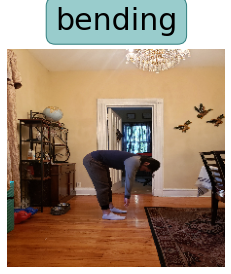

In [533]:
#Pose Prediction
  
# Blue color in BGR 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2

# Text to display
unknown_img_NN = np.expand_dims(unknown_img_classify, axis=0)
num_predict = Pose_Analyzer_Model.predict(unknown_img_NN)

num_df = pd.DataFrame(num_predict)
num_predict = np.array(num_predict)
num_predict = tf.argmax(num_predict, axis=1)
text_predict = ''
if np.array(num_predict) == 0:
    text_predict = 'squatting'
elif np.array(num_predict) == 1:
    text_predict = 'bending'
elif np.array(num_predict) == 2:
    text_predict == 'raising arms'
else:
    text_predict == 'unknown pose detected!'

plt.axis('off')
plt.imshow(cv.cvtColor(unknown_img_classify, cv.COLOR_BGR2RGB))
plt.text(112, -30, text_predict, size=30, rotation=0,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0.2, 0.5, 0.5),
                   fc=(0.6, 0.8, 0.8),
                   )
         )
plt.show()

In [534]:
text_predict

'bending'

In [535]:
output = net.forward()

In [536]:
output.shape

(1, 44, 56, 56)

In [537]:
from math import atan

In [538]:
#Left Ankle
L_ankle = points[13]

#Left Knee
L_knee = points[12]

#Left Hip
L_hip = points[11]

#Chest
chest = points[14]

In [539]:
ankle_angle = atan(abs(L_ankle[1] - L_knee[1])/ abs(L_ankle[0] - L_knee[0]))
knee_angle = atan(abs(L_knee[1] - L_hip[1])/ abs(L_knee[0] - L_hip[0]))
hip_angle = atan(abs(L_hip[1] - chest[1])/ abs(L_hip[0] - chest[0]))

In [540]:
W

56

In [541]:
knee_angle

0.06241880999595735

In [542]:
knee_flexion = (ankle_angle + knee_angle)*180/math.pi
knee_flexion

52.390409209287704

In [543]:
hip_flexion = (knee_angle + hip_angle)*180/math.pi
hip_flexion

48.57633437499736

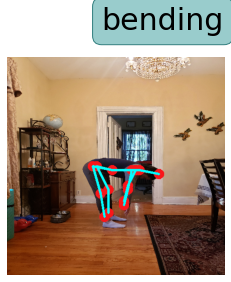

In [544]:
H = output.shape[2]
W = output.shape[3]
# Empty list to store the detected keypoints
points = []
for i in range(15):
# confidence map of corresponding body's part.
    probMap = output[0, i, :, :]
# Find global maxima of the probMap.
    minVal, prob, minLoc, point = cv.minMaxLoc(probMap)
# Scale the point to fit on the original image
    x = (2*inWidth* point[0])/H
    y = (2*inHeight* point[1])/W
    if prob:
        cv.circle(unknown_img, (int(x), int(y)), 10, (25, 22, 250), thickness=-1, lineType=cv.FILLED)
        # cv2.putText(unknown_img, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0, 0, 255), 3, lineType=cv2.LINE_AA)
# Add the point to the list if the probability is greater than the threshold
        points.append((int(x), int(y)))
    else :
	    points.append(None)

#Head(0) to Neck(1)
cv.line(unknown_img, points[0], points[1], (255, 255, 0), 3)

#Neck(1) to Chest(14)
cv.line(unknown_img, points[1], points[14], (255, 255, 0), 3)

#Chest(14) to R(8) and L Hip(11)
cv.line(unknown_img, points[14], points[8], (255, 255, 0), 3)
cv.line(unknown_img, points[14], points[11], (255, 255, 0), 3)

#Right Hip(8) to Right Knee(9)
cv.line(unknown_img, points[8], points[9], (255, 255, 0), 3)
#Right Knee(9) to Right Ankle(10)
cv.line(unknown_img, points[9], points[10], (255, 255, 0), 3)

#Left Hip(11) to Left Knee(12)
cv.line(unknown_img, points[11], points[12], (255, 255, 0), 3)
#Left Knee(12) to Left Ankle(13)
cv.line(unknown_img, points[12], points[13], (255, 255, 0), 3)

#Neck(1) to Right Shoulder(2)
cv.line(unknown_img, points[1], points[2], (255, 255, 0), 3)
#Right Shoulder(2) to Right Elbow(3)
cv.line(unknown_img, points[2], points[3], (255, 255, 0), 3)
#Right Elbow(3) to Right Wrist(4)
cv.line(unknown_img, points[3], points[4], (255, 255, 0), 3)

#Neck(1) to Left Shoulder(5)
cv.line(unknown_img, points[1], points[5], (255, 255, 0), 3)
#Left Shoulder(5) to Left Elbow(6)
cv.line(unknown_img, points[5], points[6], (255, 255, 0), 3)
#Left Elbow(6) to Left Wrist(7)
cv.line(unknown_img, points[6], points[7], (255, 255, 0), 3)

# rotate_knee = knee_angle*180/math.pi
# cv.ellipse(unknown_img,(L_knee[0],L_knee[1]),(75,75),-rotate_knee, 0, knee_flexion,(230, 80, 60),-1)

# rotate_hip = hip_angle*180/math.pi
# cv.ellipse(unknown_img,(L_hip[0],L_hip[1]),(75,75),180-rotate_knee, 0, hip_flexion,(120, 230, 230),-1)

#Pose Prediction Text
plt.text(320, -75, text_predict, size=30, rotation=0,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0.2, 0.5, 0.5),
                   fc=(0.6, 0.8, 0.8),
                   )
         )
#Angle Text Info
# plt.text(L_knee[0]-130, L_knee[1], 'Knee Flexion: \n{} degrees'.format(round(knee_flexion)), size=8, rotation=0,
#          ha="center", va="center",
#          bbox=dict(boxstyle="round",
#                    ec=(0.2, 0.5, 0.5),
#                    fc=(0.6, 0.8, 0.8),
#                    )
#          )

# plt.text(L_hip[0]+130, L_hip[1], 'Hip Flexion: \n{} degrees'.format(round(hip_flexion)), size=8, rotation=0,
#          ha="center", va="center",
#          bbox=dict(boxstyle="round",
#                    ec=(0.2, 0.5, 0.5),
#                    fc=(0.6, 0.8, 0.8),
#                    )
#          )


plt.imshow(cv.cvtColor(unknown_img, cv.COLOR_BGR2RGB))

plt.axis('off')
plt.show()